In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

In [2]:
data=pd.read_csv('./data.csv')
data['ID_DATE'] = pd.to_datetime(data['ID_DATE']) #INITIAL DRAFT DATE
data['AD_DATE'] = pd.to_datetime(data['AD_DATE'])  #LATEST ADOPTION DATE

In [3]:
# Some duplicative jurisdictions have this adu or public lands email address that doesnt name anyone working at HCD
data.JURISDICTION.value_counts()

JURISDICTION
ALAMEDA           1
CARPINTERIA       1
PACIFICA          1
PORTOLA VALLEY    1
REDWOOD CITY      1
                 ..
SHAFTER           1
TEHACHAPI         1
WASCO             1
BRADBURY          1
FILLMORE          1
Name: count, Length: 203, dtype: int64

In [4]:
data = data[~data.EMAIL.str.lower().str.contains('adu') & ~data.EMAIL.str.lower().str.contains('publiclands')]

In [5]:
data.JURISDICTION.value_counts().max()

1

In [6]:
data = data[data.ID_DATE.dt.year < 2024] # strictly speaking this should filter by COG. Dont worry about this Anne

In [7]:
data['EMAIL'] = data['EMAIL'].str.lower()


In [8]:
data.EMAIL.nunique()

33

In [9]:
data = data.replace(
    {'claire.sullivan@hcd.ca.gov': 'claire.sullivan-halpern@hcd.ca.gov',
     'halpern@hcd.ca.gov': 'claire.sullivan-halpern@hcd.ca.gov'}
)

In [10]:
data['NAME'] = data.EMAIL.str.split('@').str[0].str.split('.').str.join(' ').str.title()

In [11]:
k = 8 # this is semi-arbitrary
emails_with_enough_data = data.EMAIL.value_counts().index[data.EMAIL.value_counts() >= k]
emails_with_enough_data

Index(['jose.ayala@hcd.ca.gov', 'shawn.danino@hcd.ca.gov',
       'anthony.errichetto@hcd.ca.gov', 'jose.jauregui@hcd.ca.gov',
       'irvin.saldana@hcd.ca.gov', 'connor.finney@hcd.ca.gov',
       'hillary.prasad@hcd.ca.gov', 'claire.sullivan-halpern@hcd.ca.gov',
       'jamillah.williams@hcd.ca.gov'],
      dtype='object', name='EMAIL')

In [12]:
# Calculate the number of days between ID_DATE and AD_DATE
data['DAYS_BETWEEN'] = (data['AD_DATE'] - data['ID_DATE']).dt.days

# If DAYS BETWEEN is negative, insert the difference between today's date and the initial draft date
data['DAYS_BETWEEN2'] = (pd.to_datetime(datetime.today().date()) -  data['ID_DATE']).dt.days
data.loc[data.DAYS_BETWEEN >= 0, 'DAYS_BETWEEN2'] = data.DAYS_BETWEEN[data.DAYS_BETWEEN >= 0]

In [13]:
data_resolved = data[data.EMAIL.isin(emails_with_enough_data)]

In [14]:
data_resolved

,Unnamed: 0,JURISDICTION,EMAIL,ID_DATE,AD_DATE,COUNTY,pageCount,checkP1,checkP2,checkP3,NAME,DAYS_BETWEEN,DAYS_BETWEEN2
0,0,ALAMEDA,claire.sullivan-halpern@hcd.ca.gov,2022-08-25,2022-12-20,ALAMEDA,2,False,False,False,Claire Sullivan-Halpern,117,117
2,2,ALBANY,claire.sullivan-halpern@hcd.ca.gov,2022-12-09,2023-09-08,ALAMEDA,8,True,False,False,Claire Sullivan-Halpern,273,273
3,3,BERKELEY,jose.ayala@hcd.ca.gov,2022-11-08,2023-02-28,ALAMEDA,6,True,False,False,Jose Ayala,112,112
4,4,DUBLIN,jose.ayala@hcd.ca.gov,2022-08-29,2024-01-19,ALAMEDA,12,True,False,False,Jose Ayala,508,508
5,5,EMERYVILLE,claire.sullivan-halpern@hcd.ca.gov,2022-10-31,2023-02-03,ALAMEDA,2,False,False,False,Claire Sullivan-Halpern,95,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,181,SOLANO COUNTY,irvin.saldana@hcd.ca.gov,2023-04-06,2024-04-09,SOLANO,7,True,False,False,Irvin Saldana,369,369
182,182,SUISUN CITY,irvin.saldana@hcd.ca.gov,2022-12-28,2023-05-23,SOLANO,8,True,False,False,Irvin Saldana,146,146
183,183,VACAVILLE,irvin.saldana@hcd.ca.gov,2023-01-05,2023-09-18,SOLANO,11,True,False,False,Irvin Saldana,256,256
188,188,PETALUMA,jose.ayala@hcd.ca.gov,2023-01-27,2023-05-18,SONOMA,7,True,False,False,Jose Ayala,111,111


/var/folders/5q/4yrrbz293953sqpsf82n6d3r0000gn/T/ipykernel_24049/2265548284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_resolved['NAME'] = pd.Categorical(data_resolved['NAME'], categories=sorted_data, ordered=True)


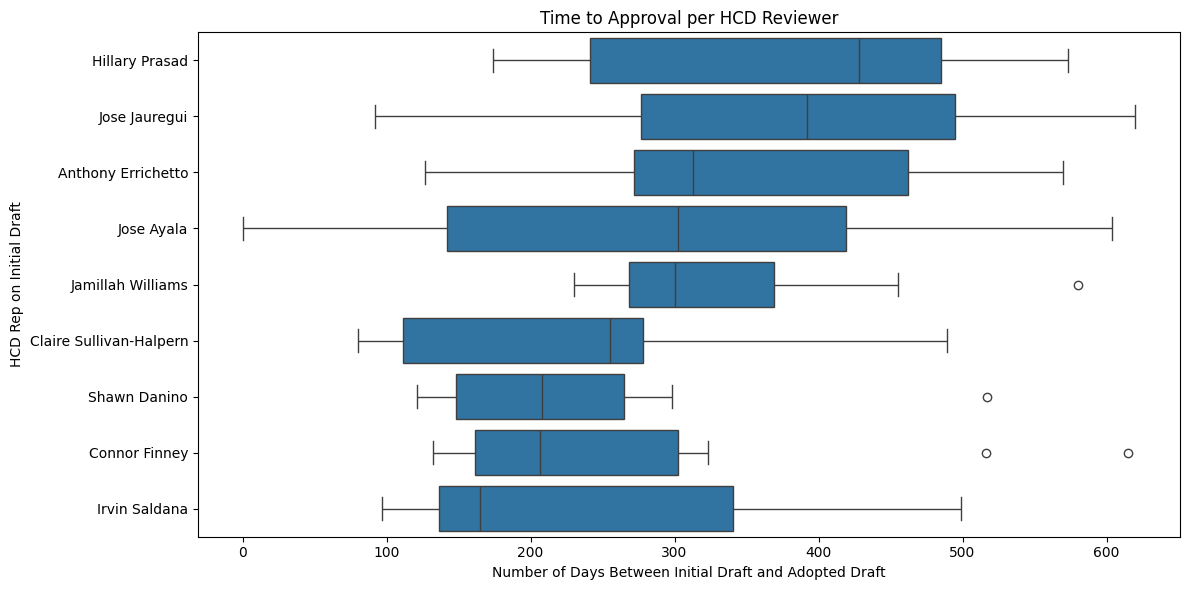

In [15]:
# Create a boxplot grouped by email
plt.figure(figsize=(12, 6))
sorted_data = data_resolved.groupby('NAME')['DAYS_BETWEEN2'].median().sort_values(ascending=False).index

# Reorder the dataframe based on the sorted order
data_resolved['NAME'] = pd.Categorical(data_resolved['NAME'], categories=sorted_data, ordered=True)

sns.boxplot(data=data_resolved, y='NAME', x='DAYS_BETWEEN2',  order=sorted_data)
plt.title('Time to Approval per HCD Reviewer')
max_days = data_resolved['DAYS_BETWEEN2'].max()
min_days= data_resolved['DAYS_BETWEEN2'].min()

plt.ylabel('HCD Rep on Initial Draft')
plt.xlabel('Number of Days Between Initial Draft and Adopted Draft')
plt.tight_layout()
plt.show()


In [16]:
data[data.NAME.str.contains('Fidel')]

,Unnamed: 0,JURISDICTION,EMAIL,ID_DATE,AD_DATE,COUNTY,pageCount,checkP1,checkP2,checkP3,NAME,DAYS_BETWEEN,DAYS_BETWEEN2
77,77,LA HABRA HEIGHTS,fidel.herrera@hcd.ca.gov,2022-06-13,2022-10-06,LOS ANGELES,9,True,False,False,Fidel Herrera,115,115
82,82,CORTE MADERA,fidel.herrera@hcd.ca.gov,2022-11-21,2023-08-15,MARIN,9,True,False,False,Fidel Herrera,267,267
89,89,SAN ANSELMO,fidel.herrera@hcd.ca.gov,2023-04-26,2024-03-28,MARIN,10,True,False,False,Fidel Herrera,337,337
185,185,CLOVERDALE,fidel.herrera@hcd.ca.gov,2023-03-09,2023-09-26,SONOMA,7,True,False,False,Fidel Herrera,201,201
190,190,SANTA ROSA,fidel.herrera@hcd.ca.gov,2022-11-01,2023-04-07,SONOMA,7,True,False,False,Fidel Herrera,157,157
191,191,SEBASTOPOL,fidel.herrera@hcd.ca.gov,2022-12-01,2023-03-07,SONOMA,7,True,False,False,Fidel Herrera,96,96
192,192,SONOMA,fidel.herrera@hcd.ca.gov,2023-01-24,2023-04-13,SONOMA,9,True,False,False,Fidel Herrera,79,79


In [17]:
data[data.NAME.str.contains('Claire')]

,Unnamed: 0,JURISDICTION,EMAIL,ID_DATE,AD_DATE,COUNTY,pageCount,checkP1,checkP2,checkP3,NAME,DAYS_BETWEEN,DAYS_BETWEEN2
0,0,ALAMEDA,claire.sullivan-halpern@hcd.ca.gov,2022-08-25,2022-12-20,ALAMEDA,2,False,False,False,Claire Sullivan-Halpern,117,117
2,2,ALBANY,claire.sullivan-halpern@hcd.ca.gov,2022-12-09,2023-09-08,ALAMEDA,8,True,False,False,Claire Sullivan-Halpern,273,273
5,5,EMERYVILLE,claire.sullivan-halpern@hcd.ca.gov,2022-10-31,2023-02-03,ALAMEDA,2,False,False,False,Claire Sullivan-Halpern,95,95
7,7,HAYWARD,claire.sullivan-halpern@hcd.ca.gov,2022-11-28,2023-07-27,ALAMEDA,9,True,False,False,Claire Sullivan-Halpern,241,241
13,13,SAN LEANDRO,claire.sullivan-halpern@hcd.ca.gov,2022-11-14,2023-02-02,ALAMEDA,5,False,False,True,Claire Sullivan-Halpern,80,80
73,73,BRADBURY,claire.sullivan-halpern@hcd.ca.gov,2022-09-01,2024-01-03,LOS ANGELES,11,True,False,False,Claire Sullivan-Halpern,489,489
141,141,GUADALUPE,claire.sullivan-halpern@hcd.ca.gov,2023-10-19,2019-05-16,SANTA BARBARA,11,True,False,False,Claire Sullivan-Halpern,-1617,269
173,173,SISKIYOU COUNTY,claire.sullivan-halpern@hcd.ca.gov,2023-03-21,2024-01-08,SISKIYOU,6,True,False,False,Claire Sullivan-Halpern,293,293


In [23]:
import os
from census import Census

from pathlib import Path 
with open(Path.home() / 'api.census_api_key', 'r') as file:
    census_api_key = file.read().strip()

c = Census(census_api_key)


census_city_data = c.acs5.state_place(['NAME', 'B01003_001E', 'B23025_001E', 'B25077_001E', 'B19013_001E'],
                                      state_fips='06',
                                      place='*')

census_city_data = [c for c in census_city_data if 'CDP' not in c.get('NAME')]

census_city_df = pd.DataFrame(census_city_data)

variable_name_map = {
    'B01003_001E': 'pop_size_acs21',
    'B23025_001E': 'num_employed_acs21',
    'B25077_001E': 'home_price_acs21',
    'B19013_001E': 'median_income_acs21'
}

census_city_df = census_city_df.rename(columns=variable_name_map)

census_city_df.NAME = census_city_df.NAME.str.split(' ').str[:-2].str.join(' ')

In [24]:
census_city_df

,NAME,pop_size_acs21,num_employed_acs21,home_price_acs21,median_income_acs21,state,place
0,Adelanto,37960.0,26817.0,276900.0,62582.0,06,00296
1,Agoura Hills,20088.0,16318.0,972000.0,157930.0,06,00394
2,Alameda,77565.0,62678.0,1147600.0,129917.0,06,00562
3,Albany,20027.0,15694.0,1129000.0,124469.0,06,00674
4,Alhambra,82295.0,69635.0,766000.0,80234.0,06,00884
...,...,...,...,...,...,...,...
477,Yountville,3397.0,3249.0,645800.0,75134.0,06,86930
478,Yreka,7833.0,5992.0,209100.0,46387.0,06,86944
479,Yuba City,69535.0,54026.0,378900.0,70412.0,06,86972
480,Yucaipa,54428.0,42017.0,429700.0,85075.0,06,87042
